In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from typing import Iterator
import torch
from torch.utils.data import Dataset

In [28]:
df = pd.read_csv('./mdshc_hk.csv')
label_columns = ['sCPS']
labels = df.loc[:, label_columns]

print(np.max(labels.to_numpy()))

6


Experiment (1), concatenate candidate mood states from section E1 and E3 for feature building

In [29]:
mood_columns = ['E1a', 'E1b', 'E1c', 'E1d', 'E1e','E1f', 'E1g', 'E1h', 'E1i', 'E3a', 'E3b', 'E3c', 'E3d', 'E3e']
exp1 = df.loc[:, mood_columns]

exp1.loc[:, 'E1a']


0        0
1        0
2        0
3        0
4        0
        ..
32711    0
32712    0
32713    0
32714    0
32715    0
Name: E1a, Length: 32716, dtype: int64

In [30]:
# fix data, experiment1.1, auto-fill zeros

exp11 = exp1.copy(deep=True)

for column in mood_columns:
    exp11.fillna({column: 0}, inplace=True)

In [31]:
# fix data, experiment1.2, auto-fill unknowns=3

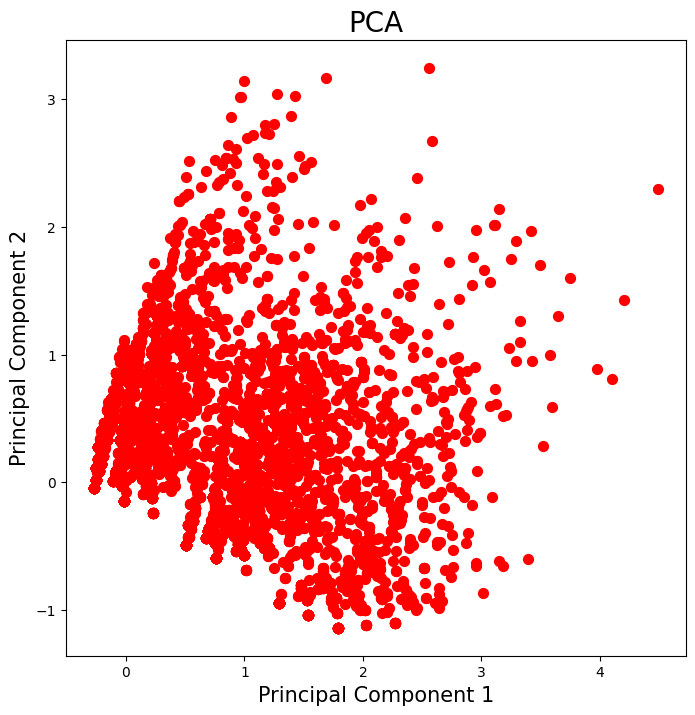

In [32]:
# without normalization, pca analysis,
# experiment 1.1, 2d after reduction
pca = PCA(n_components=2)
pca_2d_unnormalized = pca.fit_transform(exp11.values)

principalDf = pd.DataFrame(data = pca_2d_unnormalized
             , columns = ['principal component 1', 'principal component 2'])

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA', fontsize = 20)

ax.scatter(principalDf.loc[:, 'principal component 1']
               , principalDf.loc[:, 'principal component 2']
               , c = 'r'
               , s = 50)


In [33]:
# calculate covariance matrix and eigen-values
cov_matrix = np.cov(exp11.values.T, bias=True)
print(cov_matrix.shape)
eigenvalues, _ = np.linalg.eig(cov_matrix)
print(eigenvalues)

# Considering the four most principal components thereafter
pca = PCA(n_components=4)
pca_2d_unnormalized = pca.fit_transform(exp11.values)
print(type(pca_2d_unnormalized))

(14, 14)
[0.28596237 0.11894639 0.10139093 0.0111644  0.0800378  0.02246297
 0.02501309 0.06507529 0.05910083 0.03860565 0.05487777 0.04910737
 0.04544615 0.04572871]
<class 'numpy.ndarray'>


In [34]:
import random


class Exp1IterableDataset(Dataset):
    def __init__(self, feature, label, feature_columns, label_columns, seed=2023, is_infinite=True) -> None:
        self.features = feature.astype(np.float16) #feature_df.loc[:, feature_columns].to_numpy(dtype=np.float32)
        self.labels = label.astype(np.int32) #label.loc[:, label_columns].to_numpy(dtype=np.int32)
        self.dataset = np.concatenate([self.features, self.labels], axis=1)
        self.seed = seed

        self.is_infinite = is_infinite

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        length = self.__len__()
        random.seed(self.seed)
        while True:
            index = (random.randint(0, length) + index ) % length
            if self.dataset[index][-1] is None:
                print(index)
                continue
            return torch.tensor(self.dataset[index][:-1], dtype=torch.float32), torch.tensor(self.dataset[index][-1], dtype=torch.int64)
    

In [35]:
import torch.nn as nn

class FNN(nn.Module):
    def __init__(self, input_feature_dim=4) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_feature_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 7)
        )
    
    def forward(self, features):
        return self.model(features)
    
    def loss(self, x, labels):
        return nn.CrossEntropyLoss(x, labels)

In [36]:
## def train code
epochs = 1000
batch_size = 100
learning_rate = 1e-3
input_feature_dim = 4
train_test_split_size = 0.8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FNN(input_feature_dim=input_feature_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dataset = Exp1IterableDataset(feature=pca_2d_unnormalized[:int(train_test_split_size * len(exp11))], label=labels[:int(train_test_split_size * len(exp11))].to_numpy(dtype=np.int32), feature_columns=mood_columns, label_columns=label_columns)
val_dataset = Exp1IterableDataset(feature=exp11[int(train_test_split_size * len(exp11)):], label=labels[int(train_test_split_size * len(exp11)):].to_numpy(dtype=np.int32), feature_columns=mood_columns, label_columns=label_columns)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

print(len(train_dataset))

criterion = nn.CrossEntropyLoss()


for epoch in range(epochs):
    
    total_loss = 0.
    for feature, label in train_loader:
        feature = feature.to(device)
        label = label.to(device)
        
        model.train()
        optimizer.zero_grad()
        model.zero_grad()
        
        outputs = model(feature).softmax(dim=1)
        loss = criterion(outputs, label)
        loss.backward()
        
        optimizer.step()
        total_loss += loss.item()
        
    print(total_loss)
        
        


26172


/tmp/ipykernel_17271/966038146.py:24: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(self.dataset[index][:-1], dtype=torch.float32), torch.tensor(self.dataset[index][-1], dtype=torch.int64)


436.7273761034012
415.52236568927765
415.2954887151718
415.2232755422592
415.1968814134598
415.2005019187927
415.21189618110657
415.20954859256744
415.1886342763901
415.1760184764862
415.20259153842926
415.1593371629715
415.205668091774
415.201536655426
415.1741315126419
415.16232323646545
415.16609287261963
415.1854546070099
415.18149518966675
415.173664689064
415.15806019306183
415.19301199913025
415.1657522916794
415.146289229393
415.16572165489197
415.1540404558182
415.1695705652237
415.15787971019745
415.14620077610016
415.18898344039917
415.1656333208084
415.1967352628708
415.16562843322754
415.1850687265396
415.1889570951462
415.177286863327
415.14617371559143
415.19672894477844
415.1967343091965
415.1967513561249
415.18119716644287
415.17342042922974
415.15786349773407
415.15397119522095
415.15008437633514
415.1617486476898
415.17341554164886
415.20449924468994
415.18115758895874
415.16560184955597
415.16560208797455
415.1967134475708
415.17726969718933
415.1578245162964
415.20